# Twitter Sentiment Analysis

**Libraries used**

In [1]:
!pip install tweepy


In [2]:
import tweepy
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to /usr/share/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [3]:
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


**Reading Dataset**

In [4]:
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
df= pd.read_csv('../input/tweets/training.1600000.processed.noemoticon.csv' , names=DATASET_COLUMNS,encoding='latin-1')

In [5]:
df.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


**Removing unnecessary Coloumns**

In [6]:

df = df[['sentiment','text']]
df['sentiment'] = df['sentiment'].replace(4,1)
df = pd.DataFrame(df)
df

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1048571,1,My GrandMa is making Dinenr with my Mum
1048572,1,Mid-morning snack time... A bowl of cheese noo...
1048573,1,@ShaDeLa same here say it like from the Termi...
1048574,1,@DestinyHope92 im great thaanks wbuu?


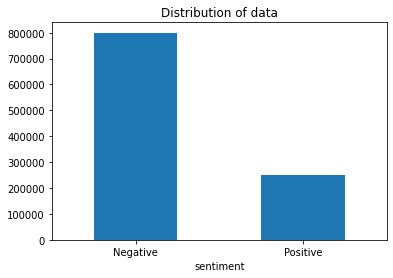

In [7]:
ax = df.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
text, sentiment = list(df['text']), list(df['sentiment'])


**Defining dictionary containing all emojis with their meanings and defining set containing all stopwords in english.**

In [8]:

emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}


stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

**Preprocessing Data**

In [9]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText


    
    

In [10]:
processedtext = preprocess(text)

**Train-Test Split**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)

**TF-IDF Vectoriser**

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

**BNB MODEL**

Score: 0.8391


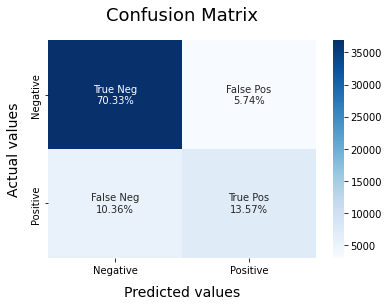

In [13]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
data_predicted = BNBmodel.predict(X_test)

cf_matrix = confusion_matrix(y_test, data_predicted)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)



score = BNBmodel.score(X_test, y_test)
print("Score: %.4f" % score)

**SVC MODEL**

Score: 0.8576


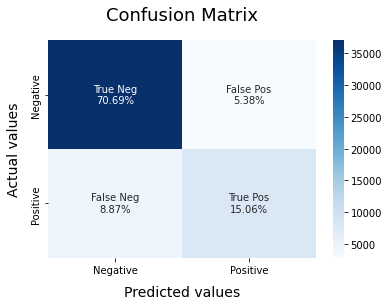

In [14]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
data_predicted = SVCmodel.predict(X_test)
cf_matrix = confusion_matrix(y_test, data_predicted )

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)



score = SVCmodel.score(X_test, y_test)
print("Score: %.4f" % score)

**LR MODEL**

Score: 0.8659


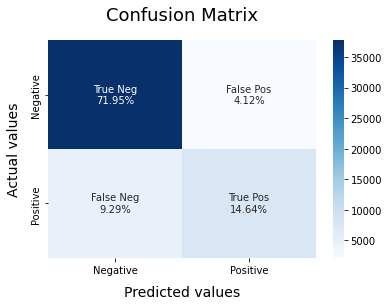

In [15]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
data_predicted = LRmodel.predict(X_test)

cf_matrix = confusion_matrix(y_test,  data_predicted)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


score = LRmodel.score(X_test, y_test)
print("Score: %.4f" % score)

**VOTING CLASSIFIER**

Score: 0.8659


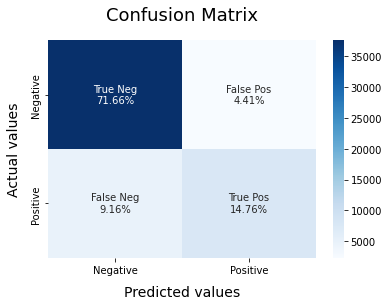

In [16]:
from sklearn.ensemble import  VotingClassifier
vclf = VotingClassifier(estimators=[('bnb', BNBmodel), ('svc', SVCmodel), ('lr', LRmodel)], voting='hard')
vclf = vclf.fit(X_train, y_train)
data_predicted = vclf.predict(X_test)

cf_matrix = confusion_matrix(y_test,  data_predicted)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


score = LRmodel.score(X_test, y_test)
print("Score: %.4f" % score)


In [17]:
data_predicted

array([1, 1, 0, ..., 1, 1, 0])

**Testing the model**

In [19]:
text = ["Dhoni was a excellent captain.",
        "Virat always fails to perform when it matters the most.",
        "Rohit is a good opening batsman",
        "Bumrah bowls well","Usain Bolt runs very fast","Millions of people died in the Kurukshetra war"]


 
textdata = vectoriser.transform(preprocess(text))
sentiment = vclf.predict(textdata)
sentiment= pd.DataFrame(sentiment)



df2=pd.DataFrame(text)
df2.columns = ['Tweet']
df2['Sentiment'] = sentiment
df2['Sentiment'] = df2['Sentiment'].replace(0,'negative')
df2['Sentiment'] = df2['Sentiment'].replace(1,'positive')

df2


,Tweet,Sentiment
0,Dhoni was a excellent captain.,positive
1,Virat always fails to perform when it matters ...,negative
2,Rohit is a good opening batsman,positive
3,Bumrah bowls well,positive
4,Usain Bolt runs very fast,positive
5,Millions of people died in the Kurukshetra war,negative
